In [43]:
import matplotlib.pyplot as plt
pot = 100
bet = np.arange(0, 10000, 1)
odd = bet/(pot+bet)

gap = 5
odd_ = np.arange(0, 100/100, 5/100)
bet_ = odd_/(1-odd_)*pot

plt.plot(bet, odd, 'b-')
plt.plot(bet_, odd_, 'ro')
plt.xlabel('bet_size')
plt.ylabel('odd')
plt.xscale('log')
plt.show()
print('bet_size', bet_)

NameError: name 'np' is not defined

[0.03075264 0.05027106 0.02276823 0.07037817 0.03341866 0.05739306
 0.04100843 0.04429544 0.03800296 0.03143655 0.03625933 0.03404033
 0.10641976 0.04190489 0.04183389 0.02950178 0.04174064 0.0279039
 0.0641496  0.08168667 0.03918984 0.03564413]


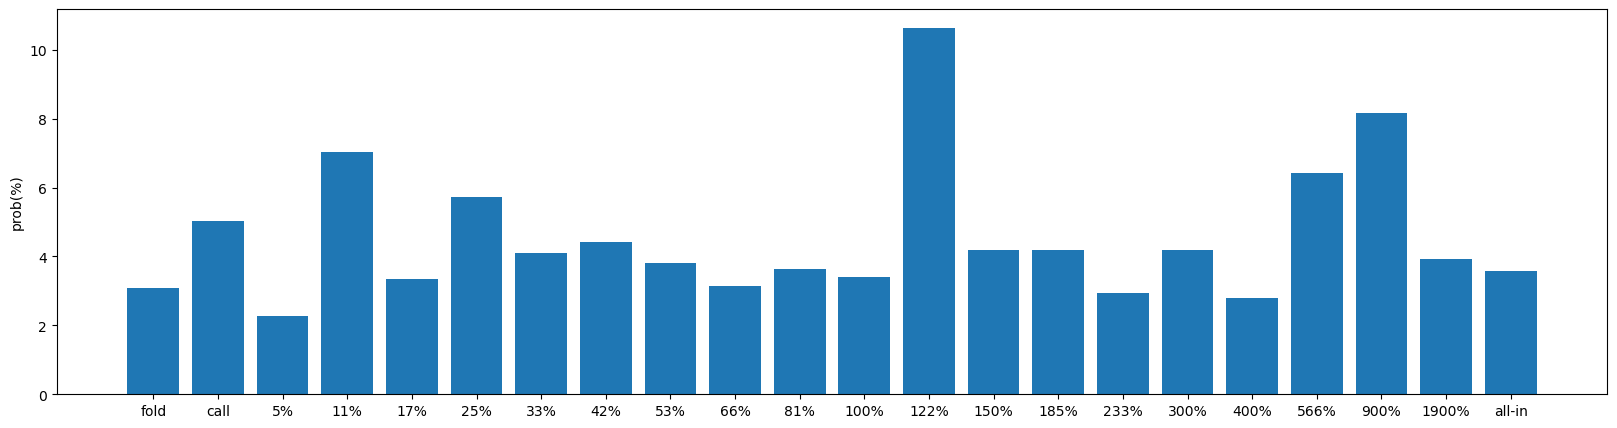

In [ ]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

class NNPolicy(nn.Module):
    def __init__(self, n_obs=20, n_act=22, hid_arch=None):
        super().__init__()

        nn_arch = (n_obs,)
        if hid_arch is None:
            nn_arch += (n_act,)
        elif isinstance(hid_arch, int) and hid_arch > 0:
            nn_arch += (hid_arch, n_act)
        elif isinstance(hid_arch, (list, tuple)) and all([isinstance(n_neu, int) and n_neu > 0 for n_neu in hid_arch]):
            nn_arch += tuple(hid_arch) + (n_act,)
        else:
            raise TypeError('hid_arch should be None, positive int, or 1d-list/tuple of positive int')
        
        n_lyr = len(nn_arch)
        net = nn.Sequential()
        for i in range(n_lyr-1):
            if i == n_lyr-2:
                net.append(nn.Linear(nn_arch[i], nn_arch[i+1]))
                net.append(nn.Softmax(dim=-1))
            else:
                net.append(nn.Linear(nn_arch[i], nn_arch[i+1]))
                net.append(nn.ReLU())

        self.net = net

    def forward(self, obs):
        obs = torch.Tensor(obs)
        return self.net(obs).numpy(force=True)
    
nnp = NNPolicy(hid_arch=None)

obs = np.random.rand(20)
pi = nnp(obs)
print(pi)

d = 5
odd = np.arange(d/100, 100/100, d/100)
bet = np.array(odd/(1-odd)*100, dtype=np.int32)

plt.figure(figsize=(20, 5))
plt.bar(np.arange(22), pi*100)
plt.xticks(
    ticks=np.arange(22),
    labels=['fold', 'call'] + [str(b)+'%' for b in bet] + ['all-in']
)
plt.ylabel('prob(%)')
plt.show()

In [ ]:
def make_act_code(odd_incr=0.05):
    odd = np.arange(odd_incr, 1, odd_incr)
    bet = np.int32(odd/(1-odd)*100)
    print(bet)

    n_code = len(bet) + 3
    code = {}
    for i in range(n_code):
        if i==0:
            code[i] = 'F'
        elif i==1:
            code[i] = 'C'
        elif i==n_code-1:
            code[i] = 'A'
        else:
            code[i] = f'B_{bet[i-2]}%'
    print(code)
    return code

len(make_act_code())

[   5   11   17   25   33   42   53   66   81  100  122  150  185  233
  300  400  566  900 1900]
{0: 'F', 1: 'C', 2: 'B_5%', 3: 'B_11%', 4: 'B_17%', 5: 'B_25%', 6: 'B_33%', 7: 'B_42%', 8: 'B_53%', 9: 'B_66%', 10: 'B_81%', 11: 'B_100%', 12: 'B_122%', 13: 'B_150%', 14: 'B_185%', 15: 'B_233%', 16: 'B_300%', 17: 'B_400%', 18: 'B_566%', 19: 'B_900%', 20: 'B_1900%', 21: 'A'}


22

In [ ]:
import torch
from tensordict.tensordict import TensorDict

In [ ]:
n = 2
td1 = TensorDict({'a': torch.rand(n, 3), 'b': torch.rand(n, 1)}, batch_size=n)

n = 5
td2 = TensorDict({'a': torch.rand(n, 3), 'b': torch.rand(n, 1)}, batch_size=n)

torch.cat((td1, td2))

TensorDict(
    fields={
        a: Tensor(shape=torch.Size([7, 3]), device=cpu, dtype=torch.float32, is_shared=False),
        b: Tensor(shape=torch.Size([7, 1]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([7]),
    device=None,
    is_shared=False)

In [61]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm
from network import PolicyNetwork, ValueNetwork

In [47]:
from env import FakeGameTorchEnv

In [51]:
from torch.distributions.categorical import Categorical

In [62]:
game = FakeGameTorchEnv()

In [145]:
pol_net = PolicyNetwork()
pol_mod = TensorDictModule(pol_net, ['obs'], ['probs'])
pol_mod = ProbabilisticActor(
    module=pol_mod,
    in_keys=['probs'],
    distribution_class=Categorical,
    return_log_prob=True
)

n = 5
tsd = TensorDict({'obs': torch.rand((n, 26), dtype=torch.float32)}, batch_size=[n])
pol_mod(tsd)
print(tsd, '\n')


TensorDict(
    fields={
        action: Tensor(shape=torch.Size([5]), device=cpu, dtype=torch.int64, is_shared=False),
        obs: Tensor(shape=torch.Size([5, 26]), device=cpu, dtype=torch.float32, is_shared=False),
        probs: Tensor(shape=torch.Size([5, 22]), device=cpu, dtype=torch.float32, is_shared=False),
        sample_log_prob: Tensor(shape=torch.Size([5]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([5]),
    device=None,
    is_shared=False) 

